Импорт библиотке 

In [13]:
import pandas as pd                                                            # модуль для работы с датафреймами
import numpy as np                                                             # модуль для работы с массивами
import matplotlib.pyplot as plt                                                # модуль для визуализации результатов
from catboost import CatBoostRegressor                                         # модуль с моделью CatBoost
from xgboost import XGBRegressor                                               # модуль с моделью XGBoost
from sklearn.neighbors import KNeighborsRegressor                              # модуль с моделью knn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score           # модули с метриками
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV                               # модуль для подбора параметров
from sklearn.preprocessing import StandardScaler                               # модуль для масштабирования данных
from sklearn.decomposition import PCA  

Загружаем данные 

In [14]:
# Чтение CSV файлов
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

# Переименование колонки "Цена на арматуру" на "Price"
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True)
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True)

# Преобразование колонки "Data" в формат datetime
train_df['dt'] = pd.to_datetime(train_df['dt'])
test_df['dt'] = pd.to_datetime(test_df['dt'])

# Объединение двух DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Сохранение объединенного DataFrame в новый CSV файл
combined_df.to_csv('combined.csv', index=False)

print("Объединение завершено. Результат сохранен в 'combined.csv'.")

Объединение завершено. Результат сохранен в 'combined.csv'.


Создание модели

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Загрузка данных
df = pd.read_csv('combined.csv', parse_dates=['dt'])
df = df.rename(columns={'Цена на арматуру': 'Price'})

# Проверка наличия необходимых колонок
assert 'Price' in df.columns, "Колонка с ценой не найдена"
assert 'dt' in df.columns, "Колонка с датой не найдена"

# Создание временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    
    for lag in range(1, 7):
        df[f'price_lag_{lag}'] = df['Price'].shift(lag)
    
    df['rolling_mean_4'] = df['Price'].rolling(4).mean().shift(1)
    df['rolling_std_4'] = df['Price'].rolling(4).std().shift(1)
    return df

df = create_features(df).dropna()

# Разделение данных
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(['dt', 'Price'], axis=1)
y_train = train['Price']
X_test = test.drop(['dt', 'Price'], axis=1)
y_test = test['Price']

# Обучение модели
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Сохранение модели с метаданными
model_data = {
    'model': model,
    'features': X_train.columns.tolist(),
    'metrics': {
        'R2': r2_score(y_test, model.predict(X_test)),
        'MSE': mean_squared_error(y_test, model.predict(X_test)),
        'MAE': mean_absolute_error(y_test, model.predict(X_test)),
        'RMSE': np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    }
}

joblib.dump(model_data, "xgboost_model.pkl")

# Прогнозирование и оценка
y_pred = model.predict(X_test)

# Метрики качества
metrics = {
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAPE': np.mean(np.abs((y_test - y_pred)/y_test)*100),
    'SMAPE': 100/len(y_test)*np.sum(2*np.abs(y_pred-y_test)/(np.abs(y_test)+np.abs(y_pred)))
}

print("Метрики качества модели:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

Метрики качества модели:
R2: 0.91
MSE: 11842882.00
MAE: 2583.88
RMSE: 3441.35
MAPE: 4.54
SMAPE: 4.54


Проверка работы модели

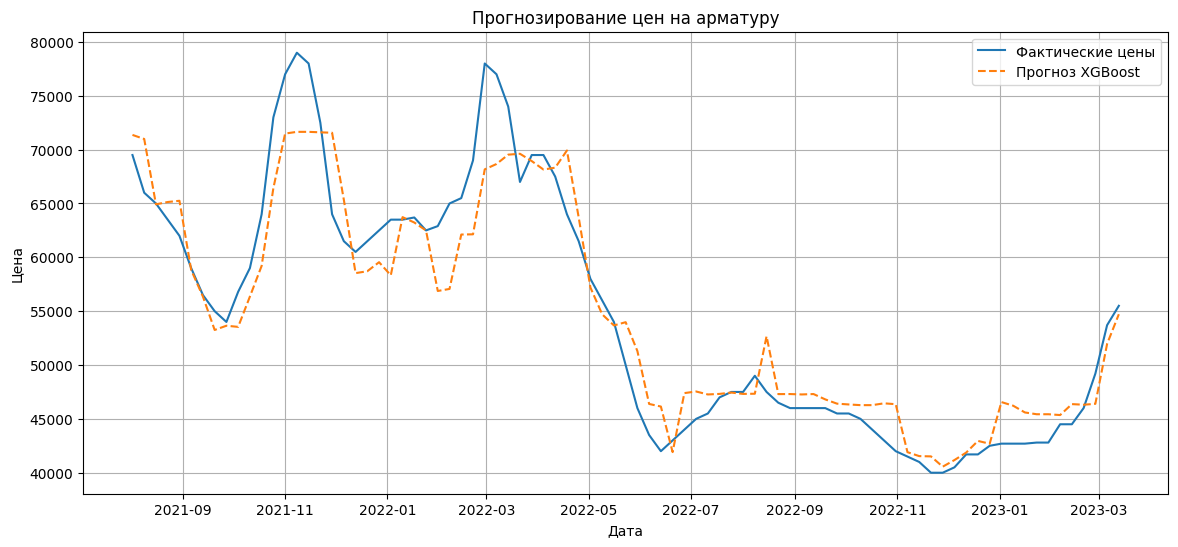

In [16]:
# Визуализация прогнозов
plt.figure(figsize=(14,6))
plt.plot(test['dt'], y_test, label='Фактические цены')
plt.plot(test['dt'], y_pred, label='Прогноз XGBoost', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

Проверка на стационарность

Ошибка загрузки файла: [Errno 2] No such file or directory: 'test1.csv'
Используем тестовые данные
Сгенерирован тестовый нестационарный ряд (случайное блуждание)

Анализ стационарности временного ряда:
Количество наблюдений: 100
Период: от 2020-01-01 00:00:00 до 2020-04-09 00:00:00


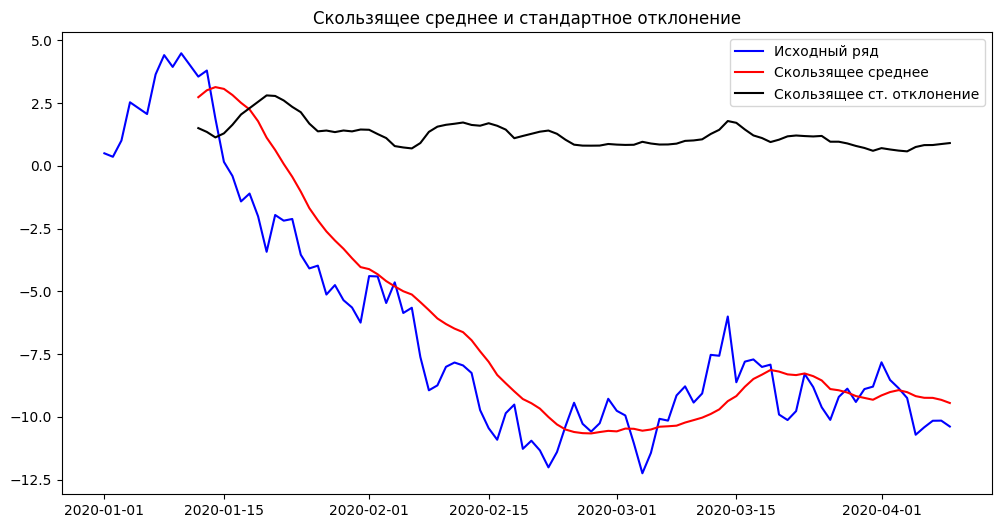

Результаты ADF теста:
Тестовая статистика           -1.358332
p-value                        0.602081
Количество лагов               0.000000
Количество наблюдений         99.000000
Критическое значение (1%)     -3.498198
Критическое значение (5%)     -2.891208
Критическое значение (10%)    -2.582596
dtype: float64

Результаты KPSS теста:
Тестовая статистика            1.257304
p-value                        0.010000
Количество лагов               5.000000
Критическое значение (10%)     0.347000
Критическое значение (5%)      0.463000
Критическое значение (2.5%)    0.574000
Критическое значение (1%)      0.739000
dtype: float64

=== Заключение о стационарности ===
ADF тест: Ряд НЕ стационарный (p-value = 0.6021)
KPSS тест: Ряд НЕ стационарный (p-value = 0.0100)
--> Вывод: Ряд НЕ СТАЦИОНАРНЫЙ

Разложение временного ряда:


C:\Users\Виктор\AppData\Local\Temp\ipykernel_12140\141244334.py:58: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(timeseries, regression='c', nlags='auto')


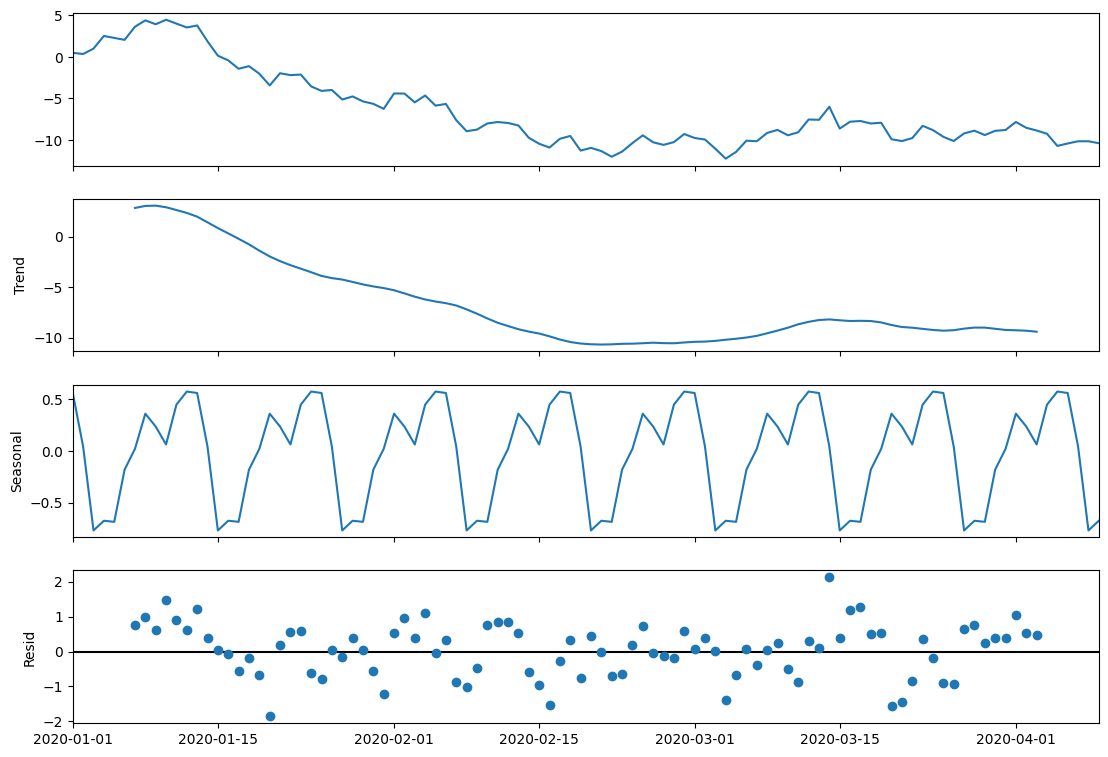


Графики ACF и PACF:


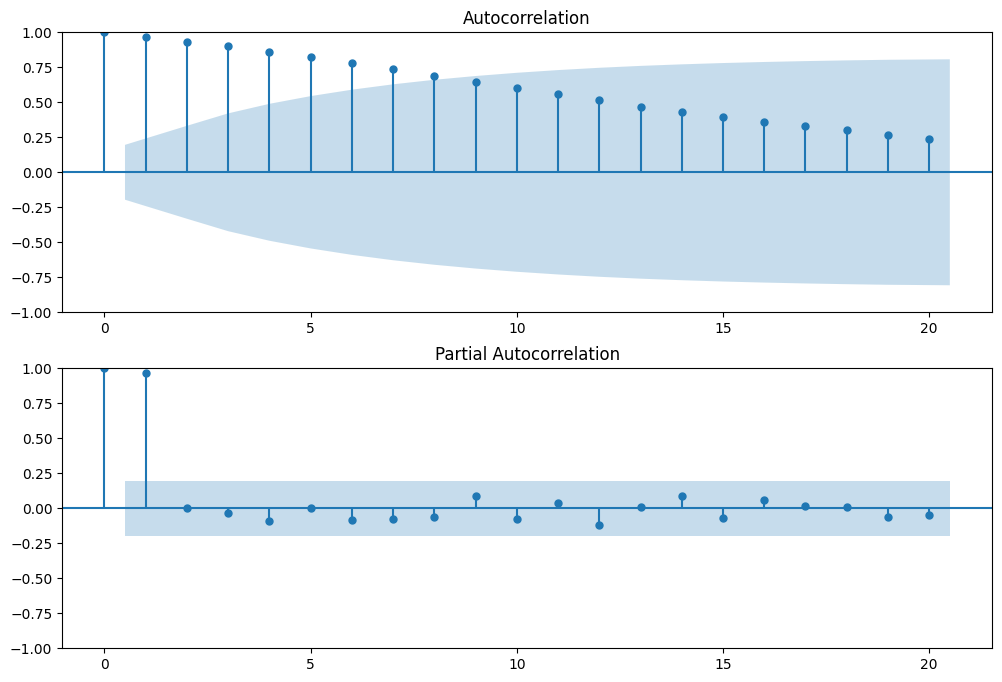

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def interpret_stationarity(adf_p, kpss_p, alpha=0.05):
    """Интерпретация результатов тестов на стационарность"""
    print("\n=== Заключение о стационарности ===")
    
    # Интерпретация ADF теста
    if adf_p <= alpha:
        print("ADF тест: Ряд стационарный (p-value = {:.4f})".format(adf_p))
    else:
        print("ADF тест: Ряд НЕ стационарный (p-value = {:.4f})".format(adf_p))
    
    # Интерпретация KPSS теста
    if kpss_p >= alpha:
        print("KPSS тест: Ряд стационарный (p-value = {:.4f})".format(kpss_p))
    else:
        print("KPSS тест: Ряд НЕ стационарный (p-value = {:.4f})".format(kpss_p))
    
    # Общее заключение
    if adf_p <= alpha and kpss_p >= alpha:
        print("--> Вывод: Ряд СТАЦИОНАРНЫЙ")
    elif adf_p > alpha and kpss_p < alpha:
        print("--> Вывод: Ряд НЕ СТАЦИОНАРНЫЙ")
    else:
        print("--> Вывод: Тесты дали противоречивые результаты. Необходим дополнительный анализ графиков.")

def test_stationarity(timeseries, window=12):
    """Проверка стационарности и вывод графиков"""
    
    # Расчет скользящих статистик
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    # График исходного ряда со скользящими статистиками
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Исходный ряд')
    plt.plot(rolmean, color='red', label='Скользящее среднее')
    plt.plot(rolstd, color='black', label='Скользящее ст. отклонение')
    plt.legend(loc='best')
    plt.title('Скользящее среднее и стандартное отклонение')
    plt.show()
    
    # ADF тест
    print('Результаты ADF теста:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Тестовая статистика','p-value','Количество лагов','Количество наблюдений'])
    for key,value in adf_test[4].items():
        adf_output[f'Критическое значение ({key})'] = value
    print(adf_output)
    
    # KPSS тест
    print('\nРезультаты KPSS теста:')
    kpss_test = kpss(timeseries, regression='c', nlags='auto')
    kpss_output = pd.Series(kpss_test[0:3], index=['Тестовая статистика','p-value','Количество лагов'])
    for key,value in kpss_test[3].items():
        kpss_output[f'Критическое значение ({key})'] = value
    print(kpss_output)
    
    # Интерпретация результатов
    interpret_stationarity(adf_test[1], kpss_test[1])
    
    # Разложение ряда
    try:
        print("\nРазложение временного ряда:")
        decomposition = seasonal_decompose(timeseries, period=window)
        fig = decomposition.plot()
        fig.set_size_inches(12, 8)
        plt.show()
    except:
        print("\nНе удалось выполнить сезонное разложение")
    
    # ACF и PACF графики
    print("\nГрафики ACF и PACF:")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(timeseries, lags=20, ax=ax1)
    plot_pacf(timeseries, lags=20, ax=ax2)
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Загрузка данных (замените на свой файл)
    try:
        # Для CSV файла
        data = pd.read_csv('test1.csv', parse_dates=['date_column'], index_col='date_column')
        # Выберите колонку с временным рядом
        ts = data['value_column']
        print("Данные успешно загружены из файла")
    except Exception as e:
        # Создаем пример данных, если файл не найден
        print(f"Ошибка загрузки файла: {e}\nИспользуем тестовые данные")
        np.random.seed(42)
        dates = pd.date_range('2020-01-01', periods=100, freq='D')
        ts = pd.Series(np.random.randn(100).cumsum(), index=dates)
        print("Сгенерирован тестовый нестационарный ряд (случайное блуждание)")
    
    # Проверка стационарности
    print("\nАнализ стационарности временного ряда:")
    print(f"Количество наблюдений: {len(ts)}")
    print(f"Период: от {ts.index.min()} до {ts.index.max()}")
    
    test_stationarity(ts)